# Temporal Clustering

In [1]:
import psycopg2, multiprocessing, psycopg2.extras, os, json, sys, time
from multiprocessing import Pool, Manager 
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
working_data = '../working_data/clustered_three_pts_with_speed/'

In [4]:
files = os.listdir(working_data)
len(files)

14042

In [120]:
def loader_function(args):
    uFile, q = args
    u = json.load(open("../working_data/clustered_three_pts_with_speed/"+uFile,'r'))
    tweets = []
    for t in u['features']:
        t['properties']['geometry'] = shape(t['geometry'])
        t['properties']['date'] = pd.Timestamp(t['properties']['date'])
        tweets.append(t['properties'])
    q.put(1)
    return gpd.GeoDataFrame(tweets)

In [121]:
#Parallel runtime
p = Pool(24)
m = Manager()
q = m.Queue()

args = [(i, q) for i in files]
result = p.map_async(loader_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)
users = result.get()

Processed: 14042, 100%

In [122]:
len(users)

14042

In [123]:
sum([len(x) for x in users])

1227699

## Quick Analysis of Spatial Cluster Numbers

In [233]:
_wk_before_str= '201210180000'
_before_str   = '201210250000'
_landfall_str = '201210300000'
_start_str    = '201210290000'
_end_str      = '201210310000'
_after_str    = '201211050000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

In [234]:
distinct_clusters_september       = []
distinct_clusters_october         = []
distinct_clusters_thru            = []

for idx, u in enumerate(users):
    distinct_clusters_one_week_before.append(len(u.query('date < {0}'.format(_wk_before_str)).cluster.value_counts()) )
    distinct_clusters_before.append(         len(u.query('date < {0}'.format(_before_str)).cluster.value_counts()) )
    distinct_clusters_thru.append(           len(u.query('date < {0}'.format(_after_str)).cluster.value_counts()) )
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))

14040

In [240]:
print("Max: "+str( (max(distinct_clusters_thru), max(distinct_clusters_before), max(distinct_clusters_one_week_before))))
print("Mean: " + str( (np.mean(distinct_clusters_thru), np.mean(distinct_clusters_before), np.mean(distinct_clusters_one_week_before))))

Max: (125, 122, 116)
Mean: (3.7757441959834783, 3.4087736789631107, 3.1427147130038455)


In [241]:
cluster_counts = pd.DataFrame({  "week_before" : distinct_clusters_one_week_before, 
                                 "before"      : distinct_clusters_before, 
                                 "week_after"  : distinct_clusters_thru})

In [392]:
sorted_cluster_counts = cluster_counts.sort_values('before', ascending=False).reset_index(drop=True)
sorted_cluster_counts['id'] = np.arange(1,len(sorted_cluster_counts)+1)
sorted_cluster_counts.head()

,before,week_after,week_before,id
0,122,125,116,1
1,101,113,96,2
2,88,94,81,3
3,78,88,76,4
4,67,75,59,5


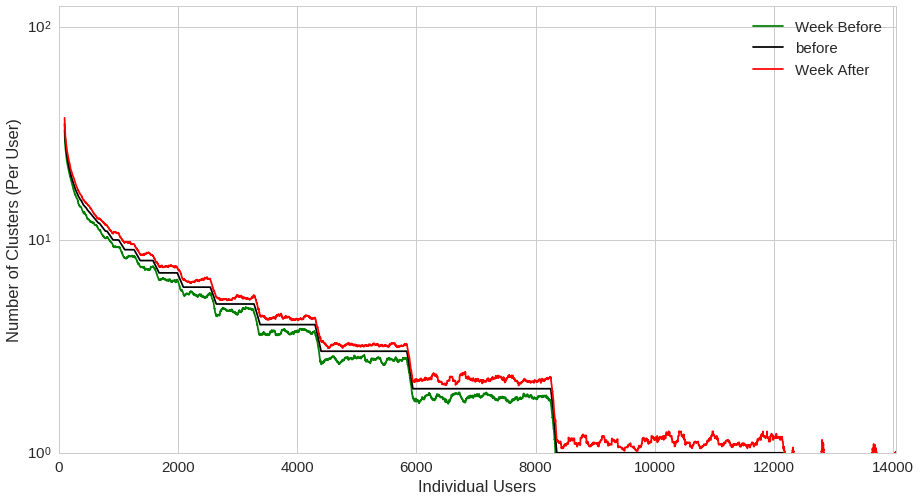

In [393]:
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)
# sorted_cluster_counts.plot(ax=ax)
sorted_cluster_counts.rolling(100).mean().plot(ax=ax, y='week_before', color='green',  label="Week Before")
sorted_cluster_counts.rolling(100).mean().plot(ax=ax, y='before',      color='black')
sorted_cluster_counts.rolling(100).mean().plot(ax=ax, y='week_after',  color='red',    label="Week After")
ax.set_ylim(1,sorted_cluster_counts.week_after.max())
ax.set_yscale('log')
ax.set_ylabel("Number of Clusters (Per User)")
ax.set_xlabel("Individual Users")
ax.legend(loc='best')
None

## Clusters Per User by Month

In [462]:
distinct_clusters_september       = []
distinct_clusters_october         = []
distinct_clusters_november        = []
for idx, u in enumerate(sorted(users, key=lambda u: len(u),reverse=True)):
    distinct_clusters_september.append(  len(u.query('date < 201210010000').cluster.value_counts()) )
    distinct_clusters_october.append(    len(u.query('date >= 201210010000 and date < 201211010000').cluster.value_counts()) )
    distinct_clusters_november.append(   len(u.query('date >= 201211010000').cluster.value_counts()) )
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))
monthly_counts = pd.DataFrame({  "september" : distinct_clusters_september, 
                                 "october"   : distinct_clusters_october, 
                                 "november"  : distinct_clusters_november} )

7950

KeyboardInterrupt: 

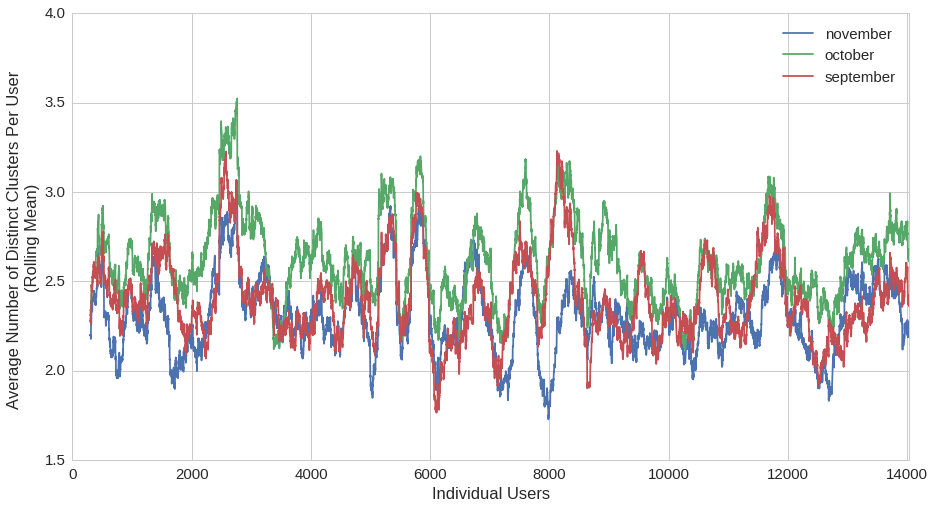

In [423]:
ax = monthly_counts.rolling(300).mean().plot()
ax.figure.set_size_inches(15,8)
ax.set_ylabel("Average Number of Distinct Clusters Per User \n(Rolling Mean)")
ax.set_xlabel("Individual Users")

In [391]:
monthly_counts.mean()

november     2.303447
october      2.615582
september    2.396667
dtype: float64

In [484]:
len(_users)

4938

In [719]:
_users[0]

,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,time_cluster,day_cluster
0,1.0,"[-73.69149255, 40.67361288]",2012-09-04 00:21:21+00:00,NaN,POINT (-73.69149255000001 40.67361288),NaN,Why cant cole be joined?,NaN,Andrewthemark,1,0
1,1.0,"[-73.69149255, 40.67361288]",2012-09-04 00:22:43+00:00,0.000000,POINT (-73.69149255000001 40.67361288),0.000000,Um... Wut.,82.0,Andrewthemark,1,0
2,1.0,"[-73.69149255, 40.67361288]",2012-09-04 00:22:57+00:00,0.000000,POINT (-73.69149255000001 40.67361288),0.000000,THEYRE CHANTING LETS GO SHEAMUS!,14.0,Andrewthemark,1,0
3,1.0,"[-73.69149255, 40.67361288]",2012-09-04 00:24:06+00:00,0.000000,POINT (-73.69149255000001 40.67361288),0.000000,Why are there only 3 commentators in vince's m...,69.0,Andrewthemark,1,0
4,1.0,"[-73.69153706, 40.67357022]",2012-09-04 00:27:03+00:00,6.049120,POINT (-73.69153706 40.67357022),0.034176,Why would they take out lawler and mathews?,177.0,Andrewthemark,1,0
5,1.0,"[-73.691537, 40.67357027]",2012-09-04 00:30:23+00:00,0.007518,POINT (-73.691537 40.67357027),0.000038,"""@Aeroparats: Harold &gt; You"" Harold &gt; Eve...",200.0,Andrewthemark,1,0
6,1.0,"[-73.69153705, 40.67357023]",2012-09-04 00:34:09+00:00,0.006129,POINT (-73.69153704999999 40.67357023),0.000027,Holy shit dolph is s god,226.0,Andrewthemark,1,0
7,1.0,"[-73.69153705, 40.67357023]",2012-09-04 00:35:23+00:00,0.000000,POINT (-73.69153704999999 40.67357023),0.000000,Great match. Better than sd match.,74.0,Andrewthemark,1,0
8,1.0,"[-73.69153705, 40.67357023]",2012-09-04 00:36:07+00:00,0.000000,POINT (-73.69153704999999 40.67357023),0.000000,YES!,44.0,Andrewthemark,1,0
9,1.0,"[-73.69153705, 40.67357023]",2012-09-04 00:36:36+00:00,0.000000,POINT (-73.69153704999999 40.67357023),0.000000,Inb4 rubber match at NOC,29.0,Andrewthemark,1,0


In [565]:
x = U.date.apply(lambda t: t.dayofweek + (t.hour / 24.0)).value_counts()

In [660]:
x.weekday()>4

False

In [661]:
def time_cluster(t):
    '''Get the timecluster'''
    hour = t.hour//4
    if t.weekday()>4:
        return hour
    else:
        returns -hour

## Diurnal Weekly Distribution?

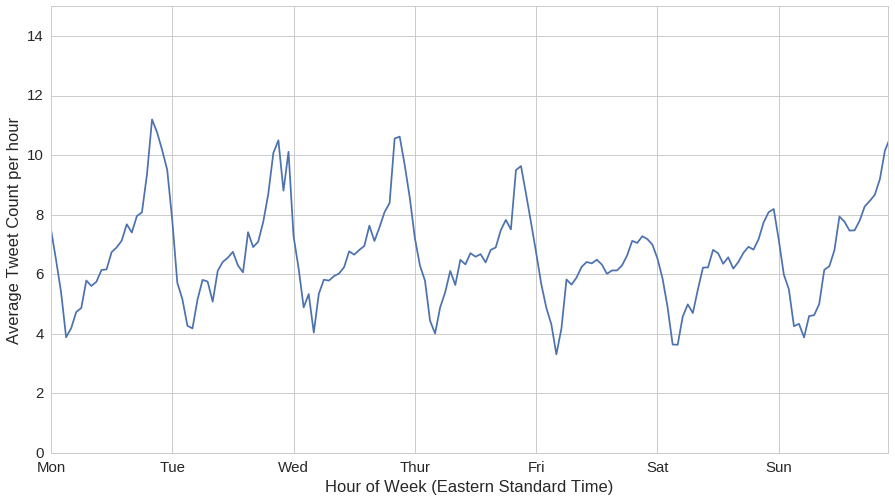

In [632]:
sns.set(font_scale=1.5); sns.set_style('whitegrid')
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)

hours = {}
for U in _users[0:500]:
    for hour, count in U.date.apply(lambda t: t.tz_convert(tz='EST').dayofweek + (t.tz_convert(tz='EST').hour / 24.0)).value_counts().items():
        if hour in hours:
            hours[hour].append(count)
        else:
            hours[hour] = [count]

_hours = []
for hour, count in hours.items():
    _hours.append( (hour, np.average(count)) )

__hours = sorted(_hours, key=lambda x: x[0])

X = pd.Series([x[0] for x in __hours])
Y = pd.Series([x[1] for x in __hours])

ax.plot(X,Y)
ax.set_xlim([-0,6.9])
ax.set_ylim([0,15])
ax.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
ax.set_xlabel("Hour of Week (Eastern Standard Time)")
ax.set_ylabel("Average Tweet Count per hour")
None

In [760]:
def time_cluster(t):
    t = t.tz_convert("EST")
    '''Get the timecluster'''
    hour = t.hour//4 + 1
    if t.weekday()>4:
        return 6+hour
    else:
        return hour

final_df = pd.DataFrame()
for U in _users[:10]:
    df = pd.DataFrame(U[['date','user']])
    df['day_cluster'] = df.date.apply(lambda t: time_cluster(t))

    final_df = final_df.append(df)

final_df.head()

,date,user,day_cluster
0,2012-09-04 00:21:21+00:00,Andrewthemark,5
1,2012-09-04 00:22:43+00:00,Andrewthemark,5
2,2012-09-04 00:22:57+00:00,Andrewthemark,5
3,2012-09-04 00:24:06+00:00,Andrewthemark,5
4,2012-09-04 00:27:03+00:00,Andrewthemark,5


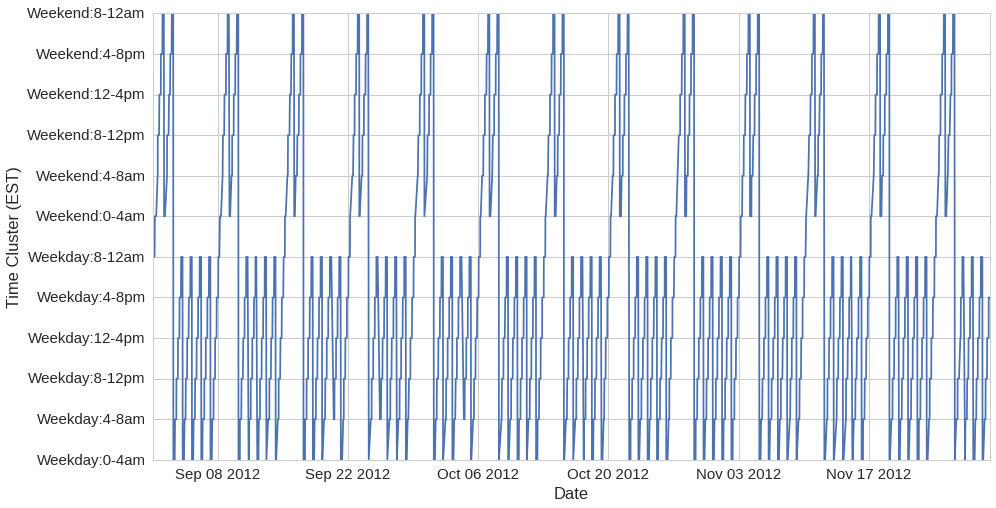

In [770]:
sns.set(font_scale=1.5); sns.set_style('whitegrid')
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)

_sorted = final_df.sort_values('date')
    
smoothed_day = _sorted['day_cluster']

ax.plot(_sorted.date, smoothed_day)

# ax.scatter(x=list(_sorted.date), y=list(smoothed_day))

ax.set_xlabel("Date")
ax.set_ylabel("Time Cluster (EST)")
ax.set_ylim(1,12)
ax.set_yticks(np.arange(1,13))
ax.set_yticklabels([
    'Weekday:0-4am','Weekday:4-8am','Weekday:8-12pm','Weekday:12-4pm','Weekday:4-8pm','Weekday:8-12am',
    'Weekend:0-4am','Weekend:4-8am','Weekend:8-12pm','Weekend:12-4pm','Weekend:4-8pm','Weekend:8-12am'
    ])
None

In [622]:
x = list(U.date)[300]

In [625]:
x, x.tz_convert(tz='EST')

(Timestamp('2012-11-28 22:06:18+0000', tz='UTC'),
 Timestamp('2012-11-28 17:06:18-0500', tz='EST'))

In [702]:
X

[datetime.datetime(2012, 9, 23, 18, 28, 19, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 23, 18, 30, 12, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 23, 18, 30, 58, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 23, 18, 42, 9, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 23, 18, 45, 41, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 23, 19, 45, 28, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 19, 1, 49, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 19, 27, 29, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 19, 29, 5, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 20, 16, 24, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 20, 33, 22, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 20, 33, 48, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 20, 35, 10, tzinfo=<StaticTzInfo 'EST'>),
 datetime.datetime(2012, 9, 25, 22, 40, 2

# Identifying Temporal Clusters
Using the same DBScan algorithm, we can find the common tweeting times for every spatial cluster

In [124]:
import numpy as np
import dbscan, imp
imp.reload(dbscan)

<module 'dbscan' from '/home/anderstj/Twitter-Movement-Derivation/TimeProcessing/dbscan.py'>

In [441]:
def worker_function(args):
    userDF, q = args
    times = np.array([list(userDF.date.astype(np.int64).apply(lambda x: x//1000000000))])
    userDF['time_cluster'] = dbscan.dbscan(times, 1*3600, 3)
    q.put(1)
    return userDF

In [442]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(worker_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.4g}%".format(size, size/len(args)*100))
        time.sleep(0.5)

users = result.get()

Processed: 14042, 100%

### Confirm that this process is working as we think it is?

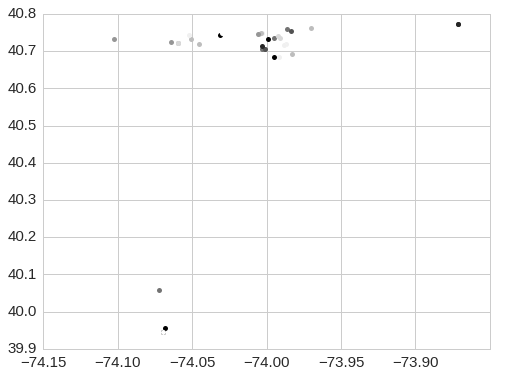

In [445]:
fig, ax = plt.subplots(1); fig.set_size_inches(8,6)
users[0].plot(ax=ax, markersize=5)

## Filter Level 1: Enough Tweets?

Ensure that we have the following for each user:
1. Geo-Cluter Information (If no geo-clusters are available, remove)
2. Enough Tweets (At least *A* Tweet during the storm)

In [446]:
_landfall_str = '201210300000'
_start_str    = '201210290000'
_end_str      = '201210310000'
_landfall = pd.Timestamp(_landfall_str)
_start    = pd.Timestamp(_start_str)
_end      = pd.Timestamp(_end_str)

In [447]:
def filter_function(args):
    df, q = args
    #If no tweets around the time of the storm, then fail.
    if len(df.query("date > %s & date < %s"%(_start_str, _end_str))) < 1:
        q.put(1)
        return None
    q.put(0)
    return df

In [448]:
#Parallel runtime
p = Pool(30)
m = Manager()
q = m.Queue()

args = [(i, q) for i in users]
result = p.map_async(filter_function, args)

# monitor loop
while True:
    if result.ready():
        break
    else:
        size = q.qsize()
        sys.stderr.write("\rProcessed: {0}, {1:.3g}%".format(size, size/len(args)*100))
        time.sleep(0.5)

values = result.get()
x = [i for i in values  if i is not None]
nones = [i for i in values  if i is None]

Processed: 14042, 100%

In [449]:
len(users), len(nones), len(x)

(14042, 9104, 4938)

In [450]:
_users = sorted(x, key=lambda y: len(y), reverse=True)

## Cluster counts for just the new users

In [451]:
_users_distinct_clusters_september       = []
_users_distinct_clusters_october         = []
_users_distinct_clusters_november        = []
for idx, u in enumerate(_users):
    _users_distinct_clusters_september.append(  len(u.query('date < 201210010000').cluster.value_counts()) )
    _users_distinct_clusters_october.append(    len(u.query('date >= 201210010000 and date < 201211010000').cluster.value_counts()) )
    _users_distinct_clusters_november.append(   len(u.query('date >= 201211010000').cluster.value_counts()) )
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))
_users_monthly_counts = pd.DataFrame({  "september" : _users_distinct_clusters_september, 
                                 "october"   : _users_distinct_clusters_october, 
                                 "november"  : _users_distinct_clusters_november} )

4930

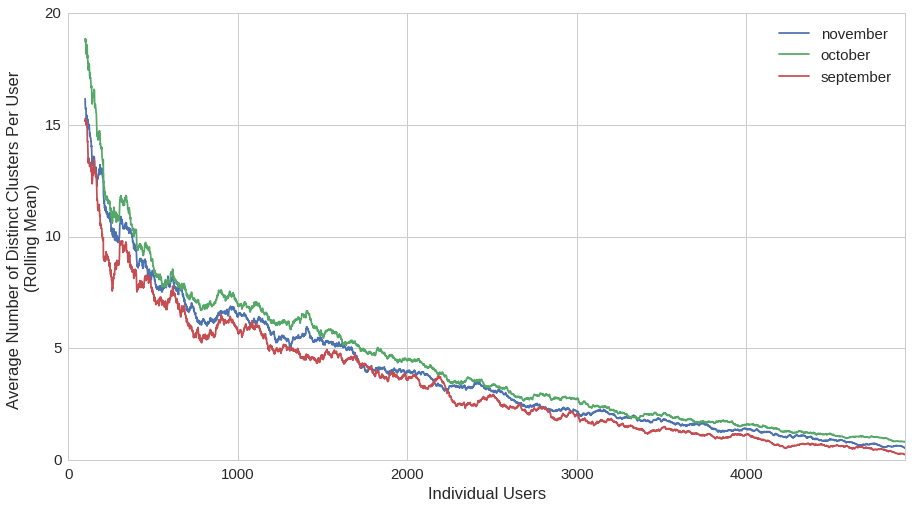

In [465]:
ax = _users_monthly_counts.rolling(100).mean().plot()
ax.figure.set_size_inches(15,8)
ax.set_ylabel("Average Number of Distinct Clusters Per User \n(Rolling Mean)")
ax.set_xlabel("Individual Users")

In [466]:
_users_monthly_counts.mean()

november     3.936817
october      4.404617
september    3.458688
dtype: float64

## Investigate the Temporal Clustering of the most prolific users

In [478]:
U = _users[2000]; len(U)

85

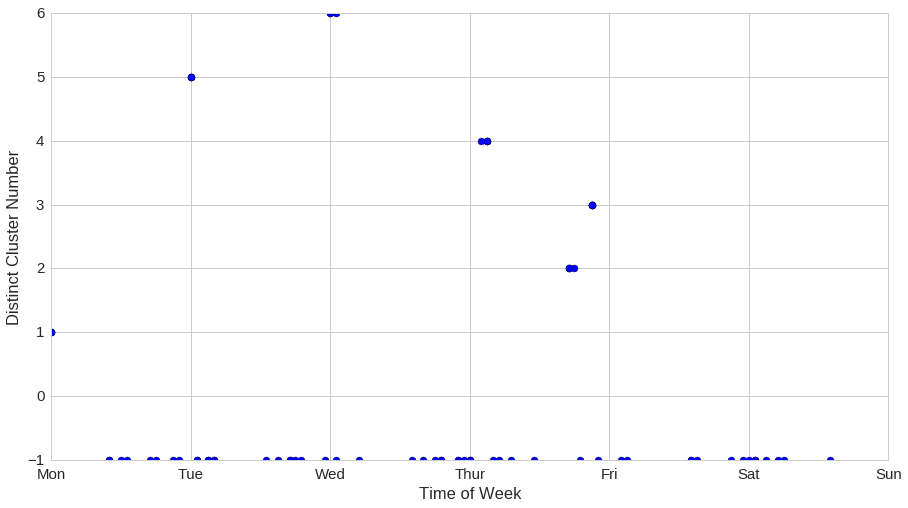

In [482]:
sns.set(font_scale=1.5); sns.set_style('whitegrid')
fig, ax = plt.subplots(1); fig.set_size_inches(15,8)
ax.scatter(
    x=list(U.date.apply(lambda t: t.dayofweek + (t.hour / 24.0))),
    y=list(U.time_cluster), s=50)
# ax.scatter(
#     x=list(U.date.apply(lambda t: t.dayofweek + (t.hour / 24.0))),
#     y=[-x for x in list(U.cluster)], s=8, color='red', marker='^')
ax.set_xlim([-0,6])
ax.set_ylim([-1,max(U.time_cluster)])
ax.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
ax.set_xlabel("Time of Week")
ax.set_ylabel("Distinct Cluster Number")
None

In [483]:
U

,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,time_cluster
0,NaN,"[-73.87427583, 40.73510214]",2012-09-02 21:54:59+00:00,NaN,POINT (-73.87427583 40.73510214),NaN,#classy birthday dinner with the greatest lady...,NaN,arrrzzz,1
1,1.0,"[-74.00435998, 40.72845517]",2012-09-05 18:27:02+00:00,10985.840762,POINT (-74.00435998 40.72845517),0.044527,@roosternewyork #beardon w/ @philorphilip @rav...,246723.0,arrrzzz,-1
2,NaN,"[-73.8660091, 40.7298514]",2012-09-06 17:09:39+00:00,11659.001531,POINT (-73.8660091 40.7298514),0.142606,@BarrettAll thanks for the follow! Status crea...,81757.0,arrrzzz,2
3,1.0,"[-74.00435998, 40.72845517]",2012-09-06 21:08:17+00:00,11659.001531,POINT (-74.00435998 40.72845517),0.814290,"I'm at Rooster (New York, NY) http://t.co/GugU...",14318.0,arrrzzz,3
4,1.0,"[-74.0048231, 40.7294013]",2012-09-06 22:46:58+00:00,112.209463,POINT (-74.0048231 40.7294013),0.018951,Hotter than the sun @ brooklyneer http://t.c...,5921.0,arrrzzz,-1
5,2.0,"[-74.0046756, 40.7212941]",2012-09-07 03:10:37+00:00,901.565195,POINT (-74.0046756 40.7212941),0.056993,@StevenRojas @SohoGrandHotel what an epic line...,15819.0,arrrzzz,-1
6,NaN,"[-73.8839525, 40.74766743]",2012-09-07 23:30:35+00:00,10586.072572,POINT (-73.88395250000001 40.74766743),0.144622,#queens @ MTA Subway - 82nd St/Jackson Heigh...,73198.0,arrrzzz,-1
7,NaN,"[-73.98792419, 40.72110038]",2012-09-08 05:19:54+00:00,9245.037511,POINT (-73.98792419 40.72110038),0.441101,Come hear good music? (@ Pianos w/ 10 others) ...,20959.0,arrrzzz,-1
8,NaN,"[-73.98792419, 40.72110038]",2012-09-08 06:32:24+00:00,0.000000,POINT (-73.98792419 40.72110038),0.000000,Just posted a photo @ Pianos http://t.co/DKX5...,4350.0,arrrzzz,-1
9,3.0,"[-73.8719237, 40.7285791]",2012-09-09 22:02:21+00:00,9810.582082,POINT (-73.8719237 40.7285791),0.068993,#Akers #49ers wow!,142197.0,arrrzzz,1


## How many time clusters per user?

In [469]:
_users_distinct_time_clusters_september = []
_users_distinct_time_clusters_october = []
_users_distinct_time_clusters_november = []
        
for idx, u in enumerate(_users):
    _users_distinct_time_clusters_september.append(  len(u.query('date < 201210010000').time_cluster.value_counts()) )
    _users_distinct_time_clusters_october.append(    len(u.query('date >= 201210010000 and date < 201211010000').time_cluster.value_counts()) )
    _users_distinct_time_clusters_november.append(   len(u.query('date >= 201211010000').time_cluster.value_counts()) )
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))
_users_monthly_tc_counts = pd.DataFrame({    "september" : _users_distinct_time_clusters_september, 
                                             "october"   : _users_distinct_time_clusters_october, 
                                             "november"  : _users_distinct_time_clusters_november} )

4930

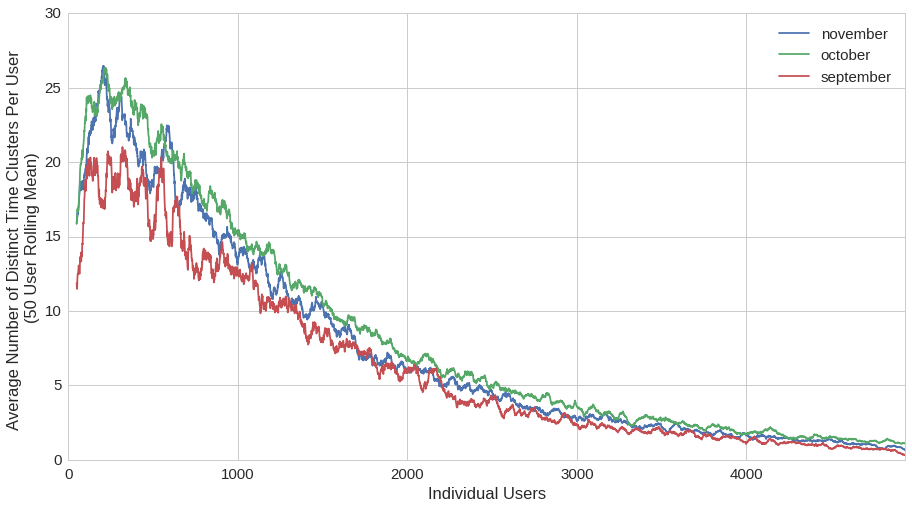

In [473]:
ax = _users_monthly_tc_counts.rolling(50).mean().plot()
ax.figure.set_size_inches(15,8)
ax.set_ylabel("Average Number of Distinct Time Clusters Per User \n(50 User Rolling Mean)")
ax.set_xlabel("Individual Users")

In [474]:
TCs = []
for idx, u in enumerate(_users):
    TCs.append(len(u.time_cluster.value_counts()))
    if idx%10==0:
        sys.stderr.write("\r"+str(idx))

4930

(array([ 2333.,   937.,   551.,   463.,   352.,   195.,    80.,    18.,
            6.,     3.]),
 array([  1. ,   6.9,  12.8,  18.7,  24.6,  30.5,  36.4,  42.3,  48.2,
         54.1,  60. ]),
 <a list of 10 Patch objects>)

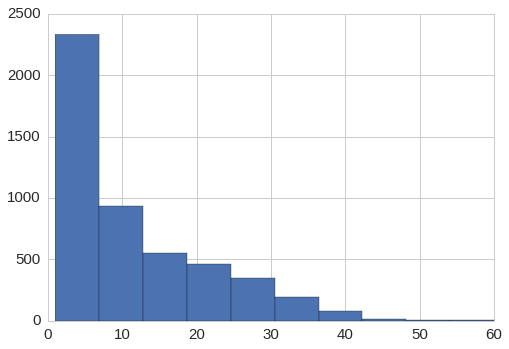

In [475]:
plt.hist(TCs)

## Group the clusters and find which geo-clusters have the most *different* time clusters

In [97]:
gb_geo = U.groupby('cluster')

In [98]:
len(gb_geo)

57

In [109]:
gb_geo['time_cluster'].agg(pd.Series.nunique).sort_values(ascending=False).head(5)

cluster
1.0     14
3.0      9
2.0      7
17.0     7
35.0     4
Name: time_cluster, dtype: int64

In [112]:
gb_geo['time_cluster'].agg(pd.Series.nunique).idxmax()

1.0

In [166]:
u['co_clustered'] = u.apply(lambda row: str(row.cluster) + "," + str(row.time_cluster), axis=1)

In [177]:
u[u.co_clustered == '3.0,4']

,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,time_cluster,combo,co-cluster,co_clustered
86,3.0,"[-73.9078851, 40.84939645]",2012-10-21 15:52:43+00:00,12374.595690,POINT (-73.9078851 40.84939645),0.201952,The Smith's &amp; The Garvey's don't have any ...,61275.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
87,3.0,"[-73.90784387, 40.84939611]",2012-10-21 15:54:51+00:00,3.468117,POINT (-73.90784386999999 40.84939611),0.027095,“@48tweetsofpower: Be royal in your fashion: a...,128.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
88,3.0,"[-73.90781439, 40.84941667]",2012-10-21 15:57:05+00:00,3.372683,POINT (-73.90781439 40.84941667),0.025169,“@SoHo_Filmz: In my own zone. Sorry if I'm not...,134.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
89,3.0,"[-73.90788314, 40.8493877]",2012-10-21 15:59:33+00:00,6.619363,POINT (-73.90788314 40.8493877),0.044725,@roro3xxi Wow are you serious! Loll You about ...,148.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
90,3.0,"[-73.90784056, 40.84941285]",2012-10-21 16:02:02+00:00,4.543959,POINT (-73.90784056 40.84941285),0.030496,“@SoHo_Filmz: People need to keep there busine...,149.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
91,3.0,"[-73.90779309, 40.84940306]",2012-10-21 16:03:13+00:00,4.138504,POINT (-73.90779309 40.84940306),0.058289,My ⚫ ⚫ hurt!! 😩,71.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
92,3.0,"[-73.90790075, 40.84939389]",2012-10-21 16:04:13+00:00,9.112653,POINT (-73.90790075 40.84939389),0.151878,Still a healing process! 🙈🙈,60.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
93,3.0,"[-73.90790072, 40.84939146]",2012-10-21 16:04:39+00:00,0.270215,POINT (-73.90790072 40.84939146),0.010393,“@Lolamjb: @EffinwitESH @shoecrazy1\nScuse me....,26.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
94,3.0,"[-73.90781169, 40.84940663]",2012-10-21 16:09:38+00:00,7.676067,POINT (-73.90781169 40.84940663),0.025672,Now the phone rings...NO RESPECT!🙈,299.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"
138,3.0,"[-73.90480357, 40.85105717]",2012-10-21 23:01:51+00:00,214.507767,POINT (-73.90480357 40.85105717),7.944732,My head hurt heads😩,27.0,EffinwitESH,4,3.0,"3.0,4","3.0,4"


In [98]:
len(_users[-100])

13

## Write these users to disk

In [231]:
os.mkdir('../working_data/spatiotemporal_clusters_filtered_two')

FileExistsError: [Errno 17] File exists: '../working_data/spatiotemporal_clusters_filtered_two'

In [232]:
import datetime
def safe_json_export(df):
    path = '../working_data/spatiotemporal_clusters_filtered_two/'
    df = df.copy()
    df['date'] = df['date'].apply(lambda t: datetime.datetime.strftime(t,'%Y-%m-%dT%H:%M:%SZ'))
#     df['time_delta'] = df['time_delta'] / np.timedelta64(1, 's')
    uName = df.head(1).user.values[0].lower()
    with open(path+uName+'.geojson','w') as oFile:
        oFile.write(df.to_json(ensure_ascii=False))

pool = Pool(24)
for i, _ in enumerate(pool.imap_unordered(safe_json_export, _users), 1):
    sys.stderr.write('\rdone {0:%}'.format(i/len(_users)))
pool.close()
pool.join()

done 100.000000%

In [119]:
len(_users)

4275

In [255]:
_users[0].head(1)

,cluster,coords,date,geo_delta,geometry,speed,text,time_delta,user,time_cluster
0,1.0,"[-73.69149255, 40.67361288]",2012-09-04 00:21:21+00:00,NaN,POINT (-73.69149255000001 40.67361288),NaN,Why cant cole be joined?,NaN,Andrewthemark,1
